In [132]:
import sys
print(sys.executable)
!{sys.executable} -m pip install pandas

/usr/local/Cellar/jupyterlab/4.2.5/libexec/bin/python

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.2.5/libexec/bin/python -m pip install --upgrade pip


In [133]:
# Package imports
import matplotlib.pyplot as plt
import pandas as pd
import ast
import numpy as np
import sqlite3

In [134]:
# Constants
DB_PATH = '../data/2024.sqlite3'

In [135]:
# Define local helper functions
import math

def degrees_to_radians(degrees):
    return degrees * (math.pi / 180.0)

def meters_to_yards(meters):
    return meters * 1.09361

def get_distance_between_points_meters(lat1, long1, lat2, long2):
    earth_radius_km = 6371
    deg_lat = degrees_to_radians(lat2 - lat1)
    deg_long = degrees_to_radians(long2 - long1)
    a = math.sin(deg_lat / 2) * math.sin(deg_lat / 2) + math.cos(degrees_to_radians(lat1)) * math.cos(degrees_to_radians(lat2)) * math.sin(deg_long / 2) * math.sin(deg_long / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist_km = earth_radius_km * c
    dist_m = dist_km * 1000
    return dist_m

def get_distance_between_points_yards(lat1, long1, lat2, long2):
    dist_m = get_distance_between_points_meters(lat1, long1, lat2, long2)
    dist_yards = meters_to_yards(dist_m)
    return dist_yards

In [136]:
# More helper functions
def parse_coordinates(coord_str):
    if pd.isnull(coord_str):
        return None  # Return None if the coordinate is null
    return ast.literal_eval(coord_str)

def parse_coordinates_with_parentheses(coord_str):
    if pd.isnull(coord_str):
        return None  # Return None if the coordinate is null
    return ast.literal_eval(coord_str[1:-1])

def distance_from_coords(row):
    if row['start_coordinate'] is None or row['end_coordinate'] is None:
        return 0
    
    return get_distance_between_points_yards(
        row['start_coordinate'][0], row['start_coordinate'][1],
        row['end_coordinate'][0], row['end_coordinate'][1]
    )


In [137]:
# Import shot data
connection = sqlite3.connect(DB_PATH)
strokes = pd.read_sql_query("SELECT * FROM round_stroke", connection)
connection.close()

# Build additional stroke columns
def fill_penalty_result(row):
    row_rnd_id = row['rnd_id']
    row_hole_id = row['hole_id']
    row_stroke_num = row['stroke_number']
    if not strokes.loc[(strokes['rnd_id'] == row_rnd_id) &\
        (strokes['hole_id'] == row_hole_id) &\
        (strokes['stroke_number'] == row_stroke_num + 1) &\
        (strokes['penalty'])].empty:
        return True
    return False
    
def fill_green_hit_result(row):
    row_rnd_id = row['rnd_id']
    row_hole_id = row['hole_id']
    row_stroke_num = row['stroke_number']
    if strokes.loc[(strokes['rnd_id'] == row_rnd_id) &\
        (strokes['hole_id'] == row_hole_id) &\
        (strokes['stroke_number'] == row_stroke_num + 1)].empty:
        return True
    return False

strokes['penalty_result'] = strokes.apply(fill_penalty_result, axis=1)
strokes['hit_green'] = strokes.apply(fill_green_hit_result, axis=1)

In [138]:
# Some helper globals
clubs_desc = ['D', '3W', '3H', '4H', '5', '6', '7', '8', '9', 'P', '50°', '56°', '62°']
clubs_asc = ['62°', '56°', '50°', 'P', '9', '8', '7', '6', '5', '4H', '3H', '3W', 'D']

clubs_wo_wedges_desc = ['D', '3W', '3H', '4H', '5', '6', '7', '8', '9', 'P']
clubs_wo_wedges_asc = ['P', '9', '8', '7', '6', '5', '4H', '3H', '3W', 'D']

wedges_desc = ['50°', '56°', '62°']
wedges_asc = ['62°', '56°', '50°']

# Section 1: Explore Club Statistics

In [139]:
original_strokes = strokes.copy(deep=True)

display(strokes.describe())
display(strokes.head())

,id,stroke_number,hole_id,rnd_id,penalty
count,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000
mean,1944.972727,2.340260,73.350000,34.592857,0.033117
std,927.680296,1.287139,69.265676,11.300081,0.179000
min,123.000000,1.000000,1.000000,11.000000,0.000000
25%,1059.750000,1.000000,10.000000,28.000000,0.000000
50%,2085.500000,2.000000,58.000000,35.000000,0.000000
75%,2752.250000,3.000000,138.000000,44.000000,0.000000
max,3368.000000,8.000000,227.000000,53.000000,1.000000


,id,club,start_coordinate,end_coordinate,stroke_number,hole_id,rnd_id,penalty,penalty_result,hit_green
0,123,8,"[39.91568444815508, -86.04792058467865]","[39.91692031566155, -86.04923497275416]",1,14,11,0,False,False
1,124,56°,"[39.91692031566155, -86.04923497275416]","[39.91668836719707, -86.04884594678879]",2,14,11,0,False,True
2,175,D,"[39.916241359532044, -86.05197742581367]","[39.91607686293417, -86.05331718921661]",1,1,11,0,False,False
3,176,7,"[39.91607686293417, -86.05331718921661]","[39.9160820059701, -86.05466902256012]",2,1,11,0,False,False
4,177,56°,"[39.9160820059701, -86.05466902256012]","[39.916056547938545, -86.05553671717644]",3,1,11,0,False,True


In [140]:
# Clean data
strokes = strokes.dropna()
strokes = strokes[strokes['club'] != 'Club'] # Times where we forgot to input club

# Convert coordinates to tuples
strokes['start_coordinate'] = strokes['start_coordinate'].astype(str).apply(parse_coordinates)
strokes['end_coordinate'] = strokes['end_coordinate'].astype(str).apply(parse_coordinates)

# Add distance column
strokes['distance'] = strokes.apply(distance_from_coords, axis=1)

strokes.describe()

,id,stroke_number,hole_id,rnd_id,penalty,distance
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000
mean,1950.317687,2.321088,72.899320,34.668707,0.0,115.398982
std,924.511876,1.295236,69.748069,11.248831,0.0,79.985502
min,123.000000,1.000000,1.000000,11.000000,0.0,0.252824
25%,1062.250000,1.000000,10.000000,28.000000,0.0,37.400791
50%,2089.500000,2.000000,56.000000,35.000000,0.0,112.328530
75%,2753.750000,3.000000,139.000000,44.000000,0.0,181.287896
max,3368.000000,8.000000,227.000000,53.000000,0.0,330.066668


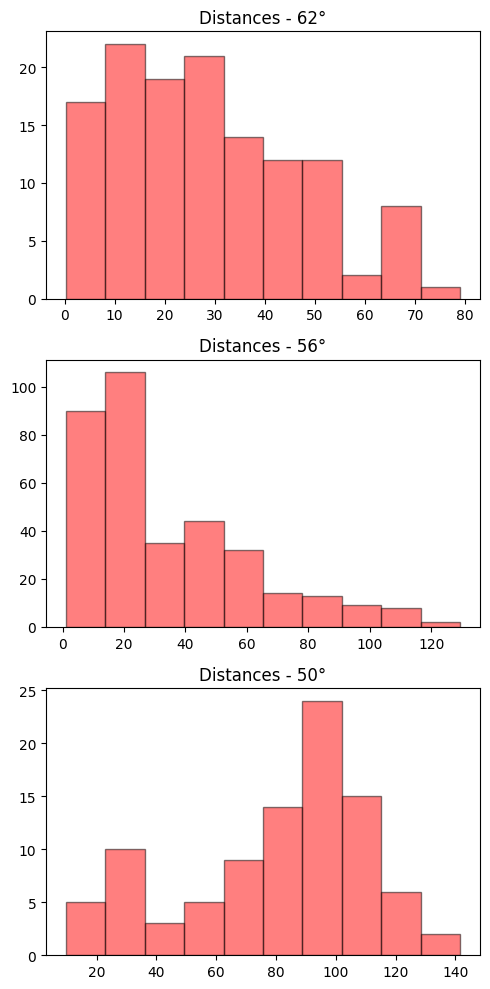

In [141]:
# Plot wedge histograms, descriptions
fig, axs = plt.subplots(3, figsize=(5, 10), tight_layout=True)
for i, wedge in enumerate(wedges_asc):
    strokes_for_wedge = strokes.where(strokes['club'] == wedge)
    axs[i].hist(x = strokes_for_wedge[['distance']], edgecolor='black', color='red', bins=10, alpha=0.5)
    axs[i].set_title(f'Distances - {wedge}')


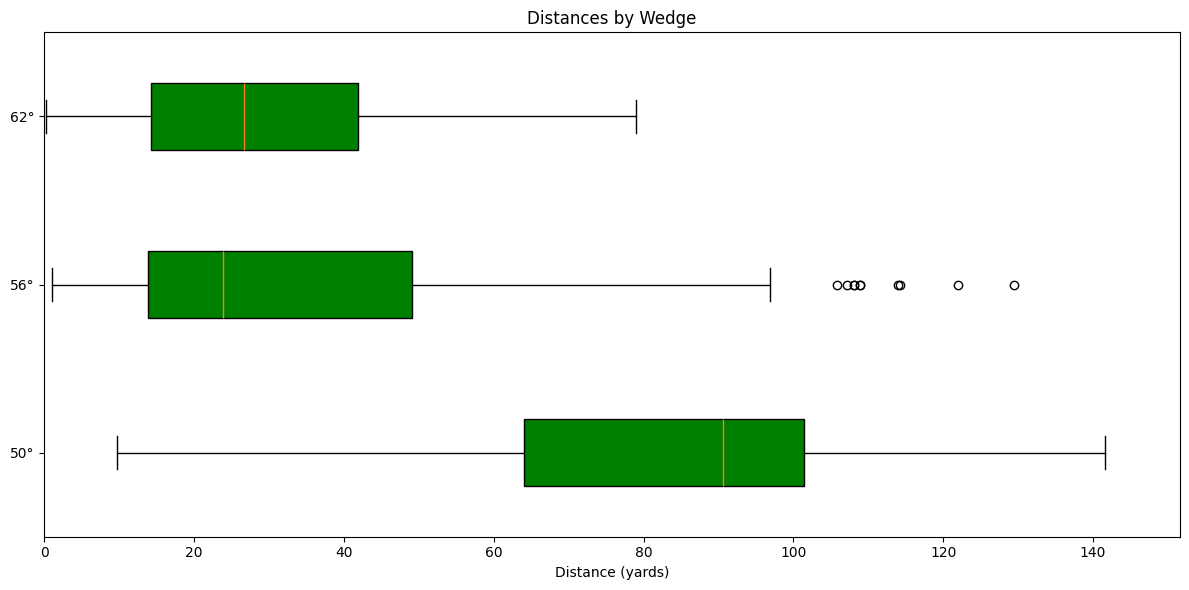

In [142]:
plt.figure(figsize=(12, 6))

# Iterate through each club to plot boxplots next to each other
for i, wedge in enumerate(wedges_desc):
    strokes_for_wedge = strokes[strokes['club'] == wedge]  # Filter strokes by club
    plt.boxplot(strokes_for_wedge['distance'], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='green', color='black', linewidth=1),  # Thicker boxes' edges
                whiskerprops=dict(color='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                positions=[i], widths=0.4)  # Adjust width to make boxes thicker

# Customize the plot
plt.title('Distances by Wedge')
plt.xlabel('Distance (yards)')
plt.yticks(range(len(wedges_desc)), wedges_desc)  # Label clubs on the y-axis
plt.xlim(0, strokes[strokes['club'] == '50°']['distance'].max() + 10)  # Adjust x-axis to fit data

# Show the plot
plt.tight_layout()
plt.show()


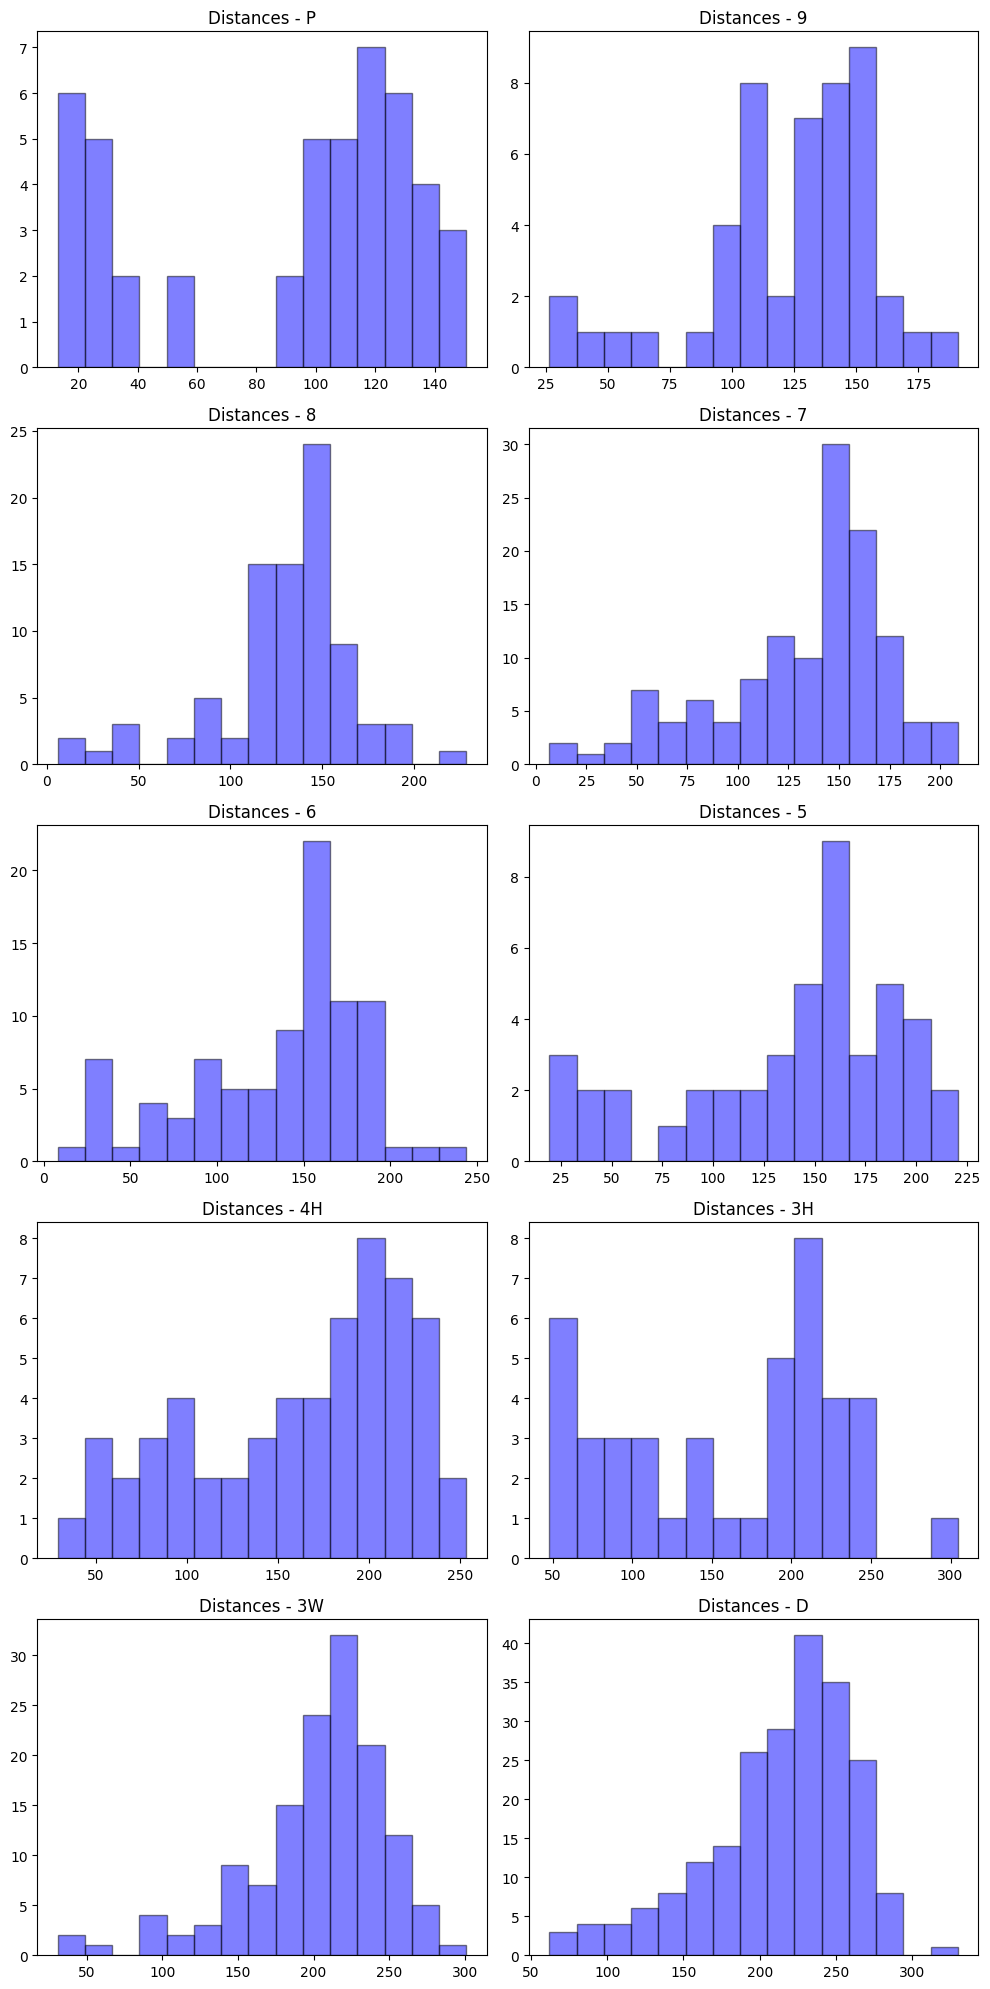

In [143]:
# Plot other club histograms
fig, axs = plt.subplots(5, 2, figsize=(10, 20), tight_layout=True)
for i, club in enumerate(clubs_wo_wedges_asc):
    strokes_for_club = strokes.where(strokes['club'] == club)
    axs[i // 2][i % 2].hist(x = strokes_for_club[['distance']], edgecolor='black', color='blue', bins=15, alpha=0.5)
    axs[i // 2][i % 2].set_title(f'Distances - {club}')

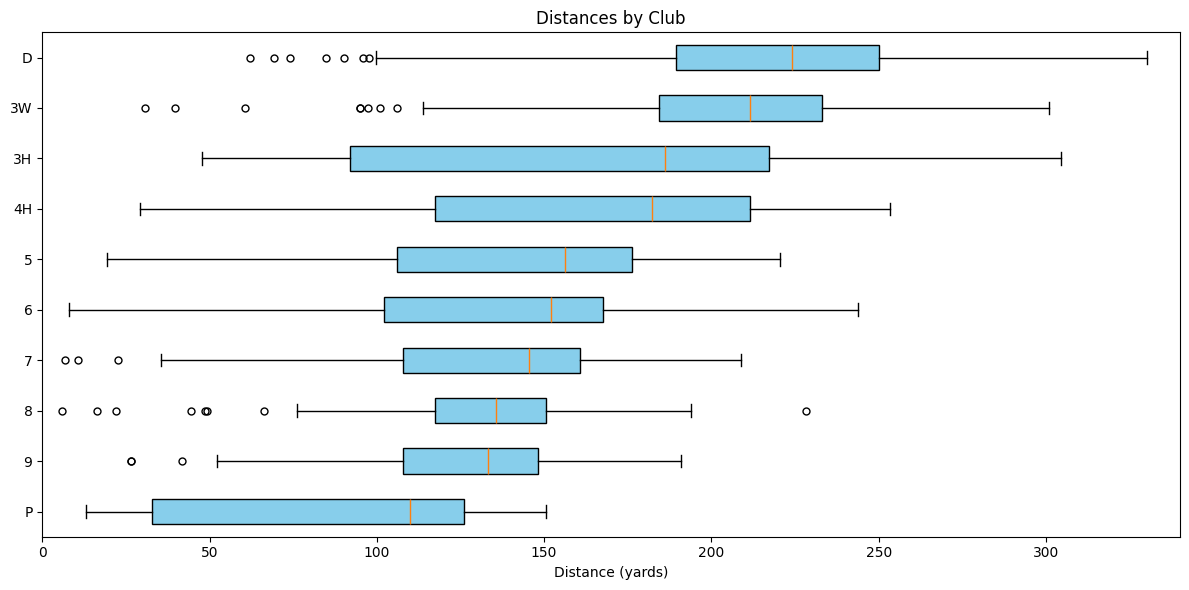

In [144]:
plt.figure(figsize=(12, 6))

# Iterate through each club to plot boxplots next to each other
for i, club in enumerate(clubs_wo_wedges_asc):
    strokes_for_club = strokes[strokes['club'] == club]  # Filter strokes by club
    plt.boxplot(strokes_for_club['distance'], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', color='black', linewidth=1),  # Thicker boxes' edges
                whiskerprops=dict(color='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                flierprops=dict(marker='o', color='red', markersize=5, linewidth=1),
                positions=[i], widths=0.5)  # Adjust width to make boxes thicker

# Customize the plot
plt.title('Distances by Club')
plt.xlabel('Distance (yards)')
plt.yticks(range(len(clubs_wo_wedges_asc)), clubs_wo_wedges_asc)  # Label clubs on the y-axis
plt.xlim(0, strokes['distance'].max() + 10)  # Adjust x-axis to fit data

# Show the plot
plt.tight_layout()
plt.show()


In [145]:
stroke_descriptions = strokes.groupby(['club'])['distance'].describe().sort_values(by='mean')
stroke_descriptions = stroke_descriptions.reindex(clubs_asc, axis=0)
display(stroke_descriptions)

,count,mean,std,min,25%,50%,75%,max
club,,,,,,,,
62°,128.0,28.683034,18.387499,0.252824,14.205895,26.698780,41.842621,79.014872
56°,353.0,33.737198,26.792650,1.031457,13.835521,23.906938,49.134610,129.490469
50°,93.0,80.492961,30.846137,9.703287,64.056417,90.596142,101.380761,141.619374
P,47.0,90.286767,46.588150,13.035304,32.813676,109.840481,125.973475,150.686426
9,48.0,122.922864,35.660082,26.404489,107.968225,133.243551,148.093331,190.887843
8,85.0,129.904977,38.369502,6.045629,117.461542,135.517331,150.589020,228.232278
7,128.0,132.436406,42.734847,6.723636,107.871000,145.552148,160.661625,208.805957
6,89.0,134.918314,50.700757,8.081561,102.270413,151.977503,167.640402,243.894000
5,45.0,137.923620,54.453733,19.428896,106.075160,156.123877,176.239725,220.560562


Text(0.5, 1.0, 'Club Distance - Maximums')

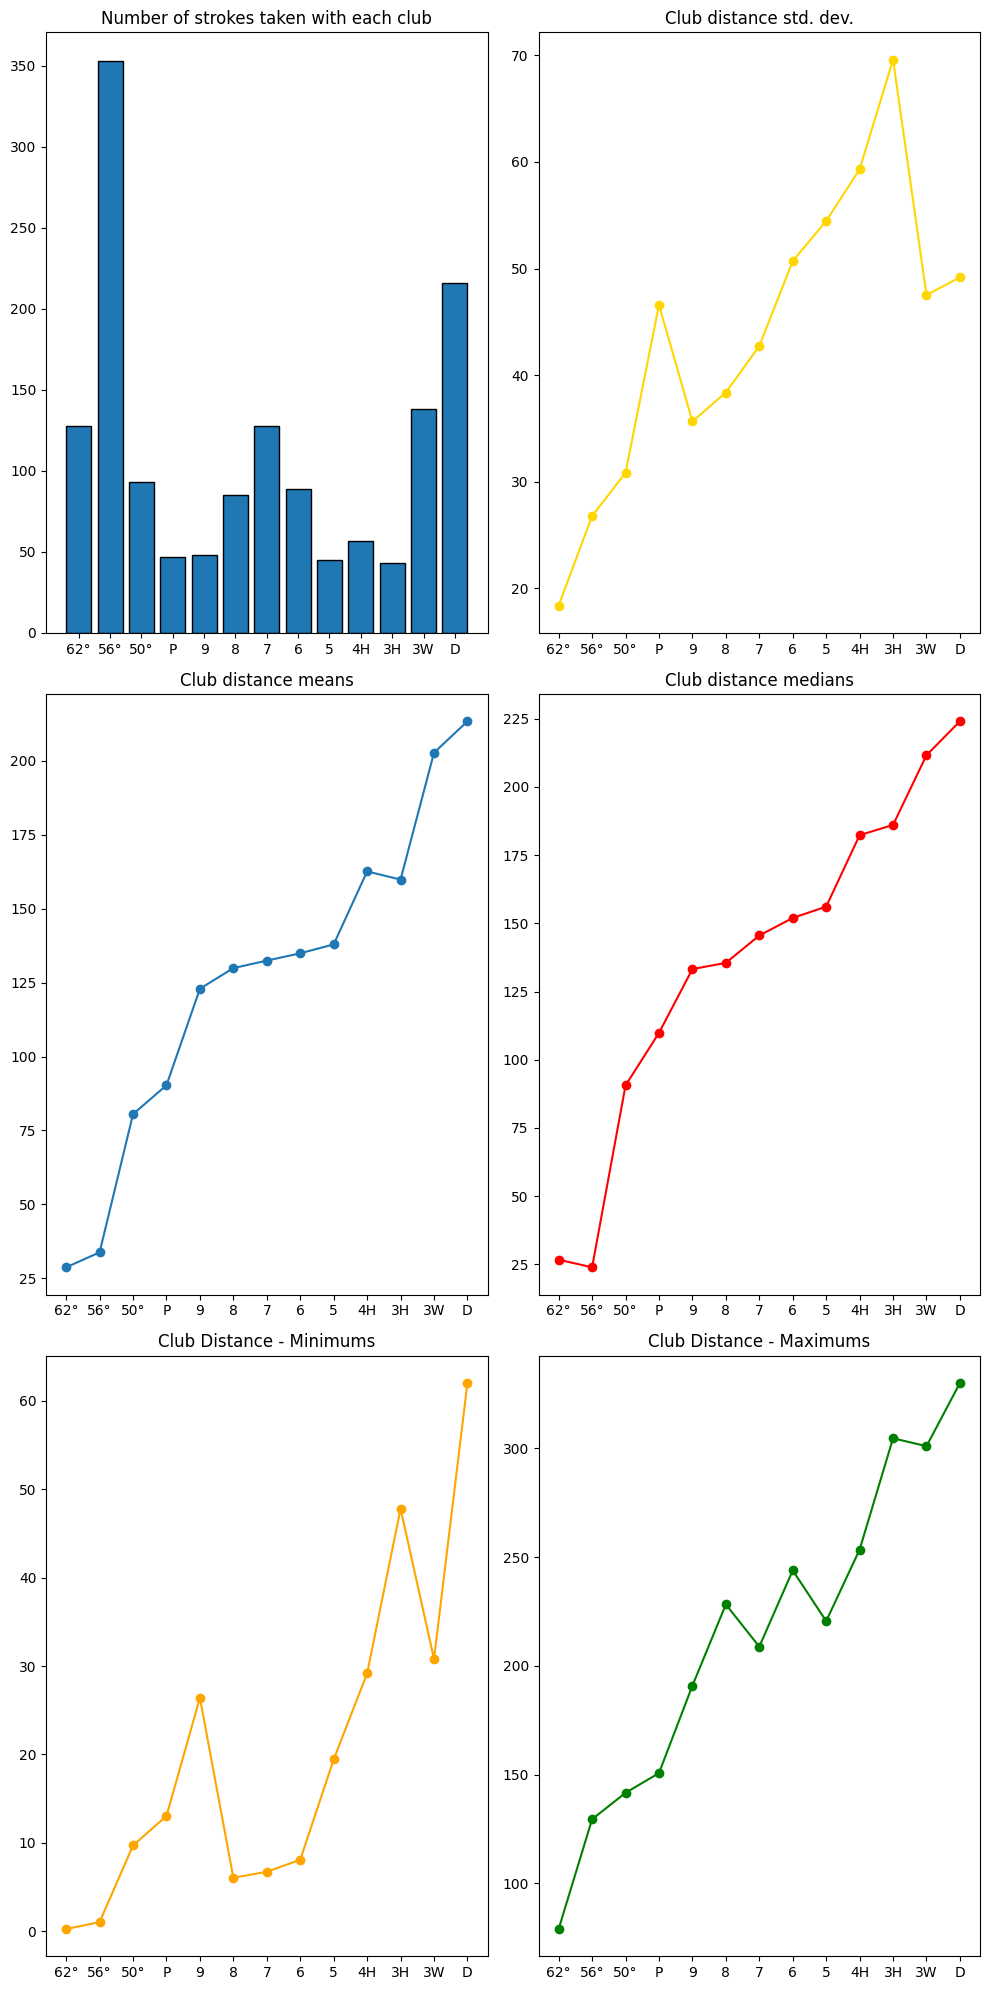

In [146]:
fig, axes = plt.subplots(3, 2, figsize=(10, 20), tight_layout=True)

# Number of Shots taken with each club
axes[0][0].bar(clubs_asc, stroke_descriptions['count'], edgecolor='black')
axes[0][0].set_title('Number of strokes taken with each club')

axes[0][1].plot(stroke_descriptions['std'], marker='o', color='gold')
axes[0][1].set_title('Club distance std. dev.')

axes[1][0].plot(stroke_descriptions['mean'], marker='o')
axes[1][0].set_title('Club distance means')

axes[1][1].plot(stroke_descriptions['50%'], marker='o', color='red')
axes[1][1].set_title('Club distance medians')

# Mins/maxes
axes[2][0].plot(stroke_descriptions['min'], marker='o', color='orange')
axes[2][0].set_title('Club Distance - Minimums')
axes[2][1].plot(stroke_descriptions['max'], marker='o', color='green')
axes[2][1].set_title('Club Distance - Maximums')

club
D      0.000000
3W     0.000000
3H     0.000000
4H     0.017544
5      0.022222
6      0.078652
7      0.156250
8      0.247059
9      0.270833
P      0.553191
50°    0.526882
56°    0.677054
62°    0.734375
dtype: float64

Text(0.5, 1.0, 'Probability of Hitting Green with Each Club')

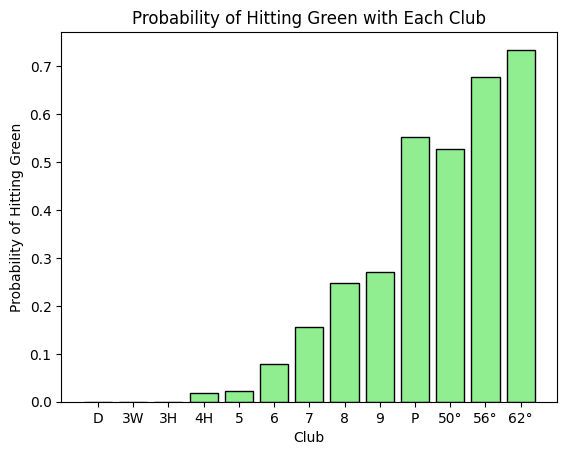

In [147]:
# Likelihood of hitting green with each club
club_strokes_with_hit_green = strokes[(strokes['hit_green'] == True) & (strokes['club'] != 'Club')]
club_strokes_with_hit_green_by_club = club_strokes_with_hit_green.groupby('club')

strokes_by_club = strokes[strokes['club'] != 'Club'].groupby('club')

hit_green_percentages_by_club = club_strokes_with_hit_green_by_club.size() / strokes_by_club.size()
hit_green_percentages_by_club = hit_green_percentages_by_club.reindex(clubs_desc)
hit_green_percentages_by_club.fillna(0, inplace=True)
display(hit_green_percentages_by_club)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(hit_green_percentages_by_club.index, hit_green_percentages_by_club, color='lightgreen', edgecolor='black')
ax.set_xlabel('Club')
ax.set_ylabel('Probability of Hitting Green')
ax.set_title('Probability of Hitting Green with Each Club')

#### On Probability of Hitting Green with Each Club Metrics

It's important to be careful with analyzing this metric - it might be tempting to think of the goal with every shot to be to hit the green, but this is not always the case. For example: second shots on Par 5's (first approach shot of the hole) usually have the goal of getting within reach for a manageable 3rd shot - going for the green is a rarity. The same logic applies to long par 4's. So while that shot may count as a 'missed' green, the intention may still be correct.

In [148]:
connection = sqlite3.connect(DB_PATH)
holes = pd.read_sql_query('SELECT * FROM course_hole', connection)
connection.close()

strokes_with_green_yardages = strokes.copy(deep=True)
strokes_with_green_yardages = strokes_with_green_yardages.merge(holes, how='inner', left_on='hole_id', right_on='id')
strokes_with_green_yardages['center_green_point'] = strokes_with_green_yardages['center_green_point'].astype('str').apply(parse_coordinates_with_parentheses)

def distance_to_green(row):
    if row['start_coordinate'] is None or row['center_green_point'] is None:
        return 0
    
    return get_distance_between_points_yards(
        row['start_coordinate'][0], row['start_coordinate'][1],
        row['center_green_point'][0], row['center_green_point'][1]
    )
strokes_with_green_yardages['dist_to_green'] = strokes_with_green_yardages.apply(distance_to_green, axis=1)

strokes_with_green_yardages.head()

,id_x,club,start_coordinate,end_coordinate,stroke_number,hole_id,rnd_id,penalty,penalty_result,hit_green,distance,id_y,hole_number,nickname,par,bound_points,center_green_point,course_id,dist_to_green
0,123,8,"[39.91568444815508, -86.04792058467865]","[39.91692031566155, -86.04923497275416]",1,14,11,0,False,False,193.944276,14,14,None,3,"[[39.915445680919575, -86.04772617176627], [39...","[39.916737836316024, -86.04879751542728]",1,151.980823
1,124,56°,"[39.91692031566155, -86.04923497275416]","[39.91668836719707, -86.04884594678879]",2,14,11,0,False,True,45.957117,14,14,None,3,"[[39.915445680919575, -86.04772617176627], [39...","[39.916737836316024, -86.04879751542728]",1,46.444422
2,175,D,"[39.916241359532044, -86.05197742581367]","[39.91607686293417, -86.05331718921661]",1,1,11,0,False,False,126.548366,1,1,None,4,"[[39.91640678790566, -86.05155433250354], [39....","[39.91607953088409, -86.05546979935548]",1,326.321511
3,176,7,"[39.91607686293417, -86.05331718921661]","[39.9160820059701, -86.05466902256012]",2,1,11,0,False,False,126.084840,1,1,None,4,"[[39.91640678790566, -86.05155433250354], [39....","[39.91607953088409, -86.05546979935548]",1,200.770700
4,177,56°,"[39.9160820059701, -86.05466902256012]","[39.916056547938545, -86.05553671717644]",3,1,11,0,False,True,80.987663,1,1,None,4,"[[39.91640678790566, -86.05155433250354], [39....","[39.91607953088409, -86.05546979935548]",1,74.687750


Text(0.5, 0, 'Approximate Range (Yards)')

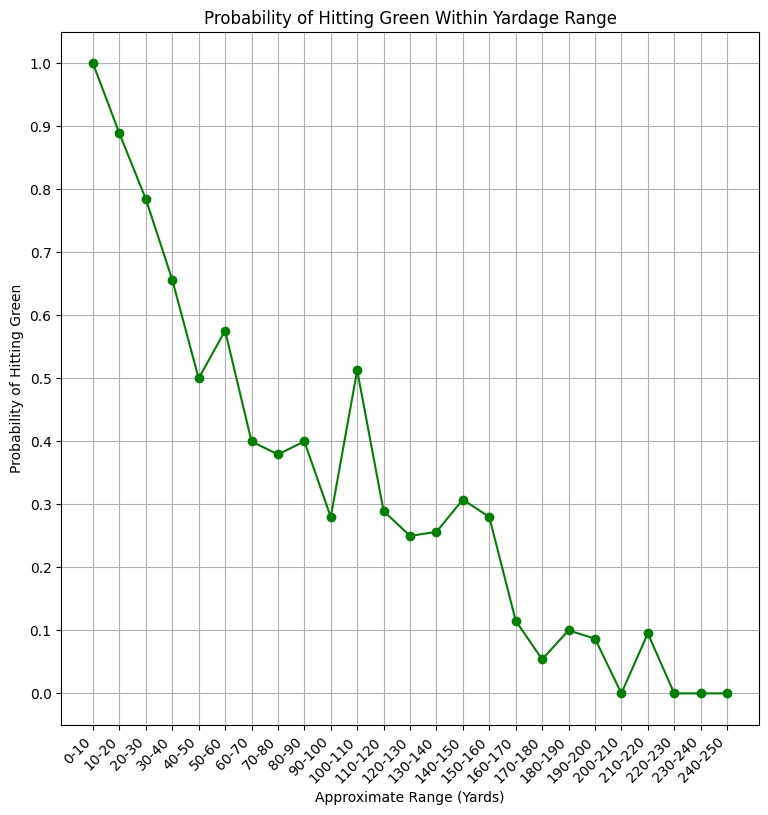

In [149]:
probs = []
labels = []
for y in range(25):
    lower = y * 10
    upper = (y + 1) * 10
    all_strokes_within_range = strokes_with_green_yardages[(strokes_with_green_yardages['dist_to_green'] > lower) & (strokes_with_green_yardages['dist_to_green'] <= upper)]
    strokes_with_range_hit_green = all_strokes_within_range[all_strokes_within_range['hit_green'] == True]
    num_strokes_within_range = len(all_strokes_within_range)
    num_strokes_within_range_hit_green = len(strokes_with_range_hit_green)
    probs.append(num_strokes_within_range_hit_green / num_strokes_within_range)
    labels.append(f"{lower}-{upper}")  # Create labels for x-ticks
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(probs, color='green', marker='o')
ax.grid(True)
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_ylabel('Probability of Hitting Green')
ax.set_title('Probability of Hitting Green Within Yardage Range')
ax.set_xticks(range(len(labels)))  # Position ticks at the indices
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Approximate Range (Yards)')


# Section 2: Penalties

In [150]:
# Display basic penalty statistics
new_strokes = original_strokes.copy(deep=True)
new_strokes = new_strokes[(new_strokes['club'] != 'Club') & (new_strokes['penalty'] != 1)]
penalty_strokes = new_strokes[new_strokes['penalty_result'] == True]

print(f'Total # of strokes taken: {len(new_strokes)}')
print(f'Total # of strokes that resulted in a penalty: {len(penalty_strokes)}')
print(f'% of strokes that result in a penalty: {(len(penalty_strokes) / len(new_strokes) * 100):.2f}%')

Total # of strokes taken: 1473
Total # of strokes that resulted in a penalty: 50
% of strokes that result in a penalty: 3.39%


In [151]:
penalties_by_club = penalty_strokes.groupby('club')
all_strokes_by_club = new_strokes.groupby('club')

penalty_percentages_by_club = penalties_by_club.size() / all_strokes_by_club.size()
penalty_percentages_by_club = penalty_percentages_by_club.reindex(clubs_desc)
penalty_percentages_by_club.fillna(0, inplace=True)

Text(0.5, 1.0, 'Probability of Shot Resulting in Penalty with Each Club')

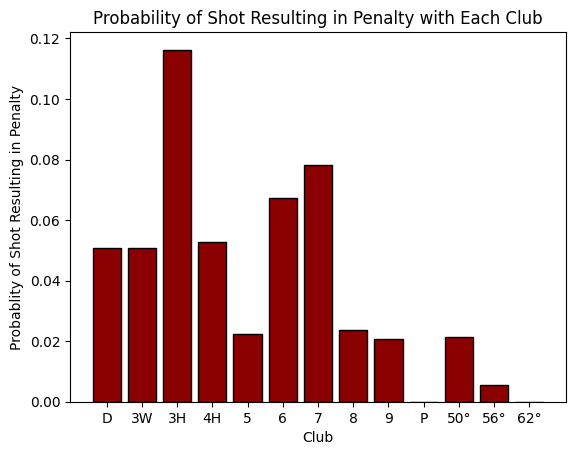

In [152]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(penalty_percentages_by_club.index, penalty_percentages_by_club, color='darkred', edgecolor='black')
ax.set_xlabel('Club')
ax.set_ylabel('Probablity of Shot Resulting in Penalty')
ax.set_title('Probability of Shot Resulting in Penalty with Each Club')

In [153]:
# Penalties by Course (How many per course, average # per round at course)

In [154]:
# Penalties by Club

# Section 4: Tee Shots

In [155]:
# Create DataFrame for tee shots
strokes = original_strokes.copy(deep=True)
tee_strokes = strokes[strokes['stroke_number'] == 1]

In [156]:
# Group tee shots and show basic use stats
tee_strokes_by_club = tee_strokes.groupby('club')

tee_strokes_by_club_count = tee_strokes_by_club.size()
tee_strokes_by_club_count = tee_strokes_by_club_count.reindex(clubs_desc)

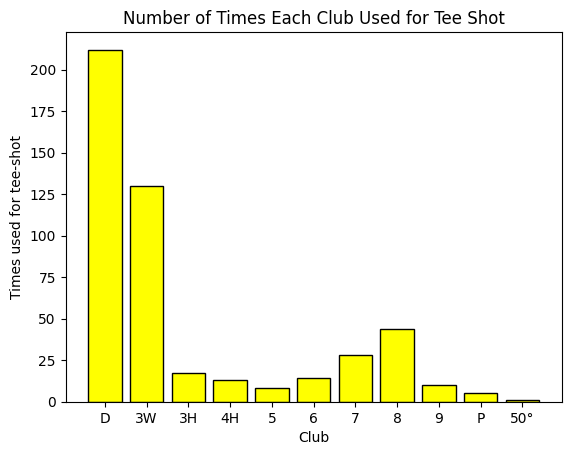

In [157]:
# Plot basic tee-shot statistics
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(tee_strokes_by_club_count.index, tee_strokes_by_club_count, color='yellow', edgecolor='black')
ax.set_xlabel('Club')
ax.set_ylabel('Times used for tee-shot')
ax.set_title('Number of Times Each Club Used for Tee Shot')
plt.show()

In [158]:
# Load stats for holes
connection = sqlite3.connect(DB_PATH)
hole_stats = pd.read_sql_query("SELECT * FROM round_holestats", connection)
connection.close()

tee_strokes = tee_strokes.merge(hole_stats, how='inner', left_on=['rnd_id', 'hole_id'], right_on=['rnd_id', 'hole_id'])
tee_strokes.head()

,id_x,club,start_coordinate,end_coordinate,stroke_number,hole_id,rnd_id,penalty,penalty_result,hit_green,id_y,gir,gld,scrambling
0,123,8,"[39.91568444815508, -86.04792058467865]","[39.91692031566155, -86.04923497275416]",1,14,11,0,False,False,18,0,0,NaN
1,175,D,"[39.916241359532044, -86.05197742581367]","[39.91607686293417, -86.05331718921661]",1,1,11,0,False,False,5,0,0,NaN
2,178,D,"[39.915801709949804, -86.05583310127258]","[39.91463268316918, -86.0565200328482]",1,2,11,0,True,False,6,0,0,NaN
3,184,3H,"[39.912743425091364, -86.05474685458147]","[39.91463268316918, -86.05413840518372]",1,3,11,0,False,False,7,1,1,NaN
4,186,7,"[39.915372649094856, -86.05398774147034]","[39.91595600147903, -86.05245351791382]",1,4,11,0,False,False,8,0,0,NaN


In [159]:
tee_shots_with_gld = tee_strokes[tee_strokes['gld'] == 1]
tee_shots_with_gld_by_club = tee_shots_with_gld.groupby('club')
tee_shots_by_club = tee_strokes.groupby('club')
gld_percentages = tee_shots_with_gld_by_club.size() / tee_shots_by_club.size()
gld_percentages.reindex(clubs_desc)
print(gld_percentages)

club
3H      0.470588
3W      0.492308
4H      0.692308
5            NaN
50°          NaN
6            NaN
7            NaN
8            NaN
9            NaN
Club    0.500000
D       0.504717
P            NaN
dtype: float64


# Section 3: Round Statistics

In [178]:
# Rounds played for year summary
connection = sqlite3.connect(DB_PATH)
rounds = pd.read_sql_query('SELECT * FROM round_round', connection)
round_strokes = pd.read_sql_query('SELECT * FROM round_stroke', connection)
round_putts = pd.read_sql_query('SELECT * FROM round_putt', connection)
courses = pd.read_sql_query('SELECT * FROM course_course', connection)
connection.close()

def get_round_full_shots(row):
    return len(round_strokes[round_strokes['rnd_id'] == row['id']])

def get_round_putts(row):
    return len(round_putts[round_putts['rnd_id'] == row['id']])

rounds['num_full_shots'] = rounds.apply(get_round_full_shots, axis=1)
rounds['num_putts'] = rounds.apply(get_round_putts, axis=1)
rounds['total_score'] = rounds['num_full_shots'] + rounds['num_putts']

# Filter rounds - we only want full rounds, score > 80
rounds = rounds[rounds['total_score'] > 80]
rounds = rounds.merge(courses, how='inner', left_on='course_id', right_on='id')
rounds.head()

,id_x,date_played,course_id,played_tee_id,finish_time,group_makeup,holes_completed,mobility,notes,round_counts_toward_hci,...,id_y,name,creation_date,address,par,designer,public,bound_points,image_url,num_holes
0,15,2024-07-25,5,9,8:40pm,Friends,18,Walking,None,0,...,5,Stony Creek Golf Club,2024-07-25 12:53:08,"11800 E 166th St, Noblesville, IN 46060",71,Sam Taylor-Sam,1,"[[40.03388253058119, -85.97090899944317], [40....",https://www.stoneycreekgolf.com/wp-content/upl...,18
1,16,2024-07-31,1,2,9:20pm,Randoms,18,Walking,None,0,...,1,Sahm Golf Course,2024-07-05 18:05:15,"6801 E 91st St, Indianapolis, IN 46250",70,Pete Dye,1,"[[39.91965709393183, -86.05598292943932], [39....",https://sahmgolf.com/wp-content/uploads/2019/0...,18
2,18,2024-08-03,1,2,None,Mixed,18,Walking,Good round w/ Jacob. That 9 on 10 really threw...,0,...,1,Sahm Golf Course,2024-07-05 18:05:15,"6801 E 91st St, Indianapolis, IN 46250",70,Pete Dye,1,"[[39.91965709393183, -86.05598292943932], [39....",https://sahmgolf.com/wp-content/uploads/2019/0...,18
3,20,2024-08-04,6,10,2:15pm,Randoms,18,Walking,Ball striking did not have a good day today. S...,0,...,6,South Grove Golf Course,2024-08-04 13:30:24,"1800 W 18th St, Indianapolis, IN 46202",70,Harry Schopp,1,"[[39.79117669387845, -86.19103789329534], [39....",https://img1.wsimg.com/isteam/ip/b2cb8392-fb37...,18
4,26,2024-08-06,1,2,None,Mixed,18,Walking,None,0,...,1,Sahm Golf Course,2024-07-05 18:05:15,"6801 E 91st St, Indianapolis, IN 46250",70,Pete Dye,1,"[[39.91965709393183, -86.05598292943932], [39....",https://sahmgolf.com/wp-content/uploads/2019/0...,18


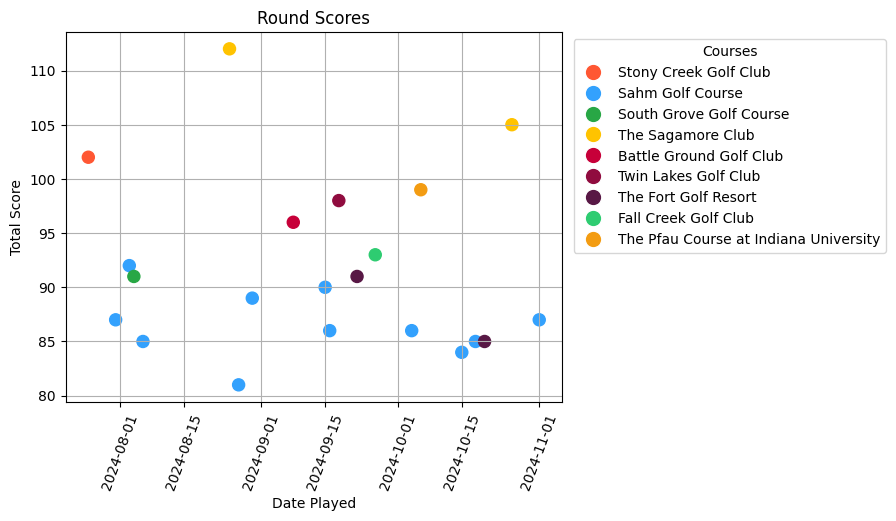

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define colors and get unique course_ids
colors = [
    "#FF5733",  # Vibrant Orange  
    "#33A1FD",  # Bright Blue  
    "#28A745",  # Fresh Green  
    "#FFC300",  # Bold Yellow  
    "#C70039",  # Deep Red  
    "#900C3F",  # Dark Magenta  
    "#581845",  # Rich Purple  
    "#2ECC71",  # Lively Lime  
    "#F39C12",  # Bright Gold  
    "#1ABC9C",  # Tropical Teal  
]

# Assume rounds['course_id'] exists in your DataFrame
course_ids = rounds['name'].unique()

# Create a dictionary to map course_ids to colors
course_color_map = {course_id: colors[i % len(colors)] for i, course_id in enumerate(course_ids)}

# Map colors to rounds based on course_id
rounds['color'] = rounds['name'].map(course_color_map)

# Prepare data for scatter plot
dates = [pd.to_datetime(d) for d in rounds['date_played']]
scatter_colors = rounds['color']  # Colors mapped to course_id

# Create the scatter plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=12, label=course_id)
    for course_id, color in course_color_map.items()
]
ax.legend(handles=legend_elements, title="Courses", bbox_to_anchor=(1.01, 1))

ax.scatter(dates, rounds['total_score'], s=75, color=scatter_colors)
ax.tick_params(axis='x', labelrotation=70)
ax.grid(True)
ax.set_title('Round Scores')
ax.set_xlabel('Date Played')
ax.set_ylabel('Total Score')
plt.show()

In [162]:
# Scatterplots - tee slope/rating vs. round score

# Regression line slope/intercepts for each course/tee played

In [163]:
# GLD Summary

In [164]:
# Scrambling Summary

In [165]:
# Hole score breakdown
# Average score on par 3/4/5
# 

# Section 4: Putting

In [166]:
# Putting summary

In [167]:
# Putting Histogram

In [168]:
# % likelihood to make for discrete distances

# Section 5: Course Statistics

Slope/Score Correlation: [[1.         0.05826794]
 [0.05826794 1.        ]]
Rating/Score Correlation: [[ 1.         -0.00999477]
 [-0.00999477  1.        ]]


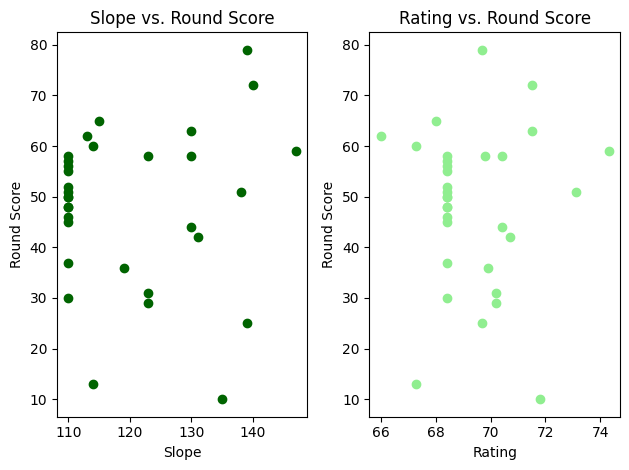

In [173]:
# Course statistics (course, # rounds played, average score, average # putts, mins/maxes)
connection = sqlite3.connect(DB_PATH)
courses = pd.read_sql_query('SELECT * FROM course_course', connection)
tees = pd.read_sql_query('SELECT * FROM course_tee', connection)
rounds = pd.read_sql_query('SELECT * FROM round_round', connection)
connection.close()

rounds = rounds[~rounds['id'].isna()]
rounds = rounds.merge(tees, how='right', left_on='played_tee_id', right_on='id')
rounds = rounds[~rounds['id_x'].isna()]
rounds['total_score'] = rounds.apply(
    lambda row: len(original_strokes.loc[original_strokes['rnd_id'] == row['id_x']]),
    axis=1
)

fix, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].scatter(rounds['slope'], rounds['total_score'], color='darkgreen')
axs[0].set_xlabel('Slope')
axs[0].set_ylabel('Round Score')
axs[0].set_title('Slope vs. Round Score')

axs[1].scatter(rounds['rating'], rounds['total_score'], color='lightgreen')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Round Score')
axs[1].set_title('Rating vs. Round Score')

r_slope = np.corrcoef(rounds['slope'], rounds['total_score'])
r_rating = np.corrcoef(rounds['rating'], rounds['total_score'])

print(f'Slope/Score Correlation: {r_slope}')
print(f'Rating/Score Correlation: {r_rating}')

# Section 6: Other fun things